In [1]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib
import ast

In [2]:
ptype_lookup = {'meet': [98, 99], 'teams': [102, 123], 'webex': [102, None]}
vcas = ['meet', 'teams', 'webex']

In [3]:
def process_ptype(x):
    ls = []
    x = ast.literal_eval(x)
    for a in x:
        if isinstance(a, str):
            ls.append(int(a.split(',')[0]))
        else:
            ls.append(int(a))
    return ls

In [4]:
dfs = {}
for vca in vcas:
    df = pd.read_csv(f'../../data/{vca}_frame_stats.csv', index_col=False)
    df = df.drop('Unnamed: 0', axis=1)
    df['max_udp_length'] = df['udp_length_list'].apply(lambda x: max(x))
    df['ptype_list'] = df['ptype_list'].apply(process_ptype)
    df['vid_count'] = df['ptype_list'].apply(lambda x: x.count(ptype_lookup[vca][0]))
    df['rtx_count'] = df['ptype_list'].apply(lambda x: x.count(ptype_lookup[vca][1]))
    df['marker_sum'] = df['marker_list'].apply(lambda x: sum(ast.literal_eval(x)))
    df['time_list'] = df['time_list'].apply(lambda x: ast.literal_eval(x))
    df['time_span'] = df['time_list'].apply(lambda x: max(x) - min(x))
    df['rank_list'] = df['rank_list'].apply(lambda x: ast.literal_eval(x))
    df['rank_range'] = df['rank_list'].apply(lambda x: max(x) - min(x))
    dfs[vca] = df

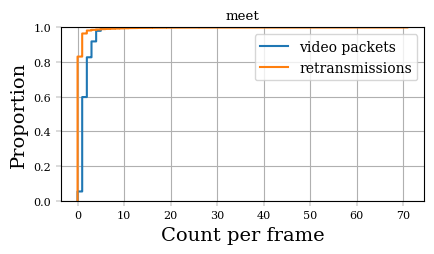

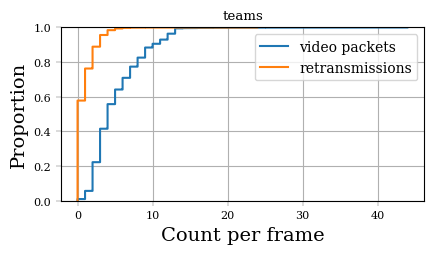

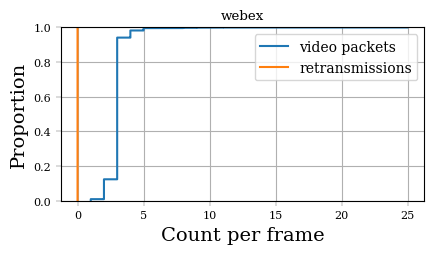

In [5]:
for vca in vcas:
    plt.figure()
    sns.ecdfplot(data=dfs[vca], x = 'vid_count')
    sns.ecdfplot(data=dfs[vca], x = 'rtx_count')
    plt.title(vca)
    plt.grid(visible=1)
    plt.xlabel('Count per frame')
    plt.legend(labels=['video packets', 'retransmissions'])

<AxesSubplot: xlabel='max_abs_intra_diff', ylabel='Proportion'>

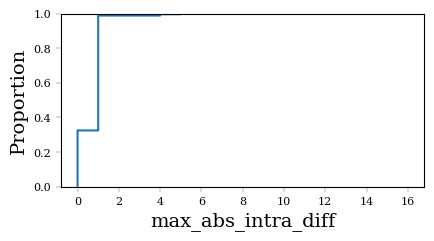

In [6]:
w = dfs['teams']
sns.ecdfplot(data=w[w['rtx_count'] == 0], x = 'max_abs_intra_diff')

For teams, the maximum intra-frame size difference is either 0 or 1 in cases when there are no retransmissions.

(753867, 28)
3.1784020480000024


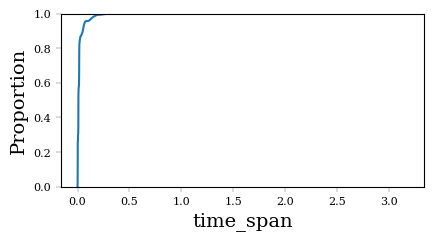

In [173]:
m = dfs['webex']
# m['seq_no_list'] = m['seq_no_list'].apply(lambda x: ast.literal_eval(x))
m['no_breaks'] = m['seq_no_list'].apply(lambda x: list(range(int(min(x)), int(max(x)+1))) == sorted(list(map(int , x))))
m = m[(m['rtx_count'] == 0) & (m['marker_sum'] == 1) & (m['no_breaks'] == True) & (m['frame_length'] > 1)]
print(m.shape)
sns.ecdfplot(data=m, x = 'time_span')
print(m['time_span'].max())

<AxesSubplot: xlabel='max_abs_intra_diff', ylabel='Proportion'>

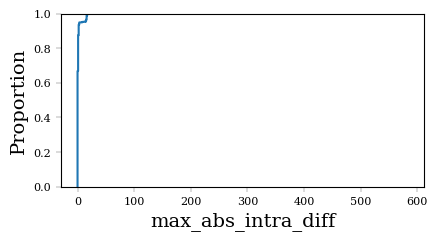

In [27]:
m = dfs['meet']
sns.ecdfplot(data = m, x = 'rank_range')

In [30]:
m['rank_range'].quantile(0.98)

16.0